In [24]:
import numpy as np
import matplotlib.pyplot as plt

import simon_64_128
import simon_64_128_simulation
import logger

from helper import *
from measurement import Measurements, Measurement

rng = np.random.default_rng()

In [25]:
NUM_MEASUREMENTS = 1000
VALS_PER_MEASUREMENT = 45
CORR_DIFF_THRESHOLD = 0.05

# Perform Simulated Measurements with random plaintexts

In [27]:
key = rng.integers(0, 2**32, 4, dtype=np.uint32)

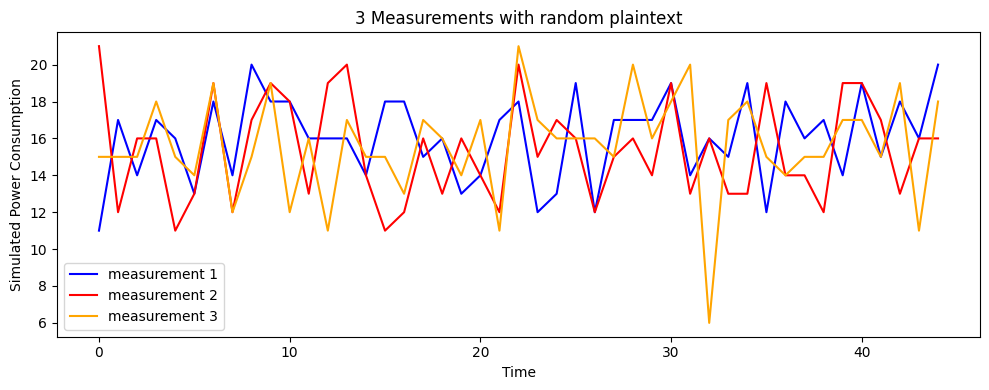

In [28]:
 # Perform 1000 simulated measurements
measurements = Measurements()

for i in range(NUM_MEASUREMENTS):
    plaintext = rng.integers(0, 2**32, 2, dtype=np.uint32)
    ciphertext, log = simon_64_128.encrypt_block(plaintext, key)
    power = simon_64_128_simulation.log_to_simulated_power(log)
    measurements.append(Measurement(plaintext, ciphertext, power))

measurements.update_power_2d()

# Draw 3 simulated traces
plt.figure(figsize=(10,4))
vals1 = measurements[0].power
vals2 = measurements[1].power
vals3 = measurements[2].power

plt.plot(vals1, color='blue', label='measurement 1')
plt.plot(vals2, color='red', label='measurement 2')
plt.plot(vals3, color='orange', label='measurement 3')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Simulated Power Consumption")
plt.title("3 Measurements with random plaintext")
plt.tight_layout()
plt.show()


# Simulated Measurement for 3 specific plaintexts

The graph shows that a plaintext of [FFFFFFFF, FFFFFFFF] will result in a high power consumption at the beginning. The plaintext [00000000, 00000000] has a low power consumption at the beginning.

In the beginning, the plaintexts [00000000, 00000000] and [00000001, 00000000] have a similar graph.

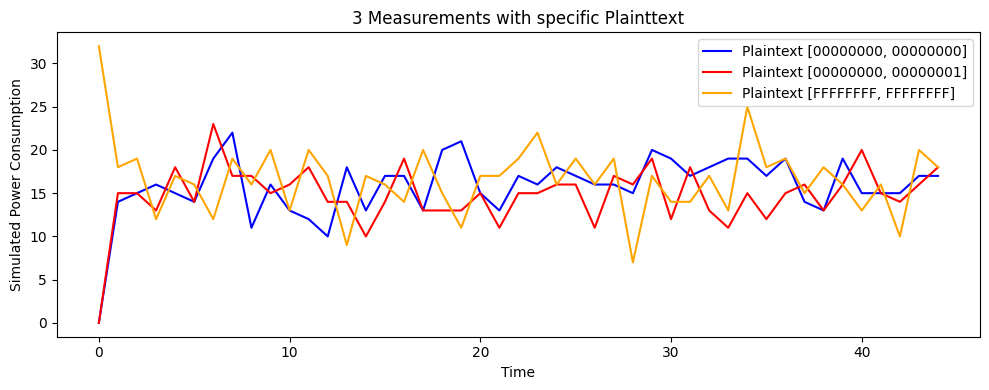

In [30]:
plaintext1 = np.array([0,0], dtype=np.uint32)
_, log1 = simon_64_128.encrypt_block(plaintext1, key)

plaintext2 = np.array([0,1], dtype=np.uint32)
_, log2 = simon_64_128.encrypt_block(plaintext2, key)

plaintext3 = np.array([0xFFFFFFFF,0xFFFFFFFF], dtype=np.uint32)
_, log3 = simon_64_128.encrypt_block(plaintext3, key)

current_consumption1 = simon_64_128_simulation.log_to_simulated_power(log1)
current_consumption2 = simon_64_128_simulation.log_to_simulated_power(log2)
current_consumption3 = simon_64_128_simulation.log_to_simulated_power(log3)

plt.figure(figsize=(10,4))
vals1 = current_consumption1
vals2 = current_consumption2
vals3 = current_consumption3

plt.plot(vals1, color='blue', label='Plaintext [00000000, 00000000]')
plt.plot(vals2, color='red', label='Plaintext [00000000, 00000001]')
plt.plot(vals3, color='orange', label='Plaintext [FFFFFFFF, FFFFFFFF]')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Simulated Power Consumption")
plt.title("3 Measurements with specific Plainttext")
plt.tight_layout()
plt.show()

# Attack

In [31]:
# start with empty key as hypothesis
empty_key = np.zeros((4,), dtype=np.uint32)
start_hypo = KeyHypothesis(empty_key, 0)

promising_hypos = [start_hypo]

for attack_step in range(16):
    print(f"Perform Attack Step {attack_step+1}/16")

    sub_hypos: list[KeyHypothesis] = []

    for h in promising_hypos:
        sub_hypos.extend(h.get_sub_hypos())

    print(f"Find correlations for {len(sub_hypos)} hypotheses.")

    for hypo in sub_hypos:
        calc_corr_for_hypo(hypo, measurements)

    promising_hypos = filter_hypos(sub_hypos, CORR_DIFF_THRESHOLD)

    print(f"Found {len(promising_hypos)} promising hypotheses.")
    for hypo in promising_hypos:
        
        print(f"{array_to_hex_str(hypo.key)}: correlation: {hypo.corr}")

if len(promising_hypos) > 0:
    # Do final check against ciphertext
    for hypo in promising_hypos:
        ciphertext, _ = simon_64_128.encrypt_block(measurements[0].plaintext, hypo.key)
        if np.array_equal(measurements[0].ciphertext, ciphertext):
            extracted_key = hypo.key
            print(f"Extracted Key: {array_to_hex_str(extracted_key)}")
            break
else:
    print("Could not determine key")


Perform Attack Step 1/16
Find correlations for 256 hypotheses.
Found 2 promising hypotheses.
0x00000000 0x00000000 0x00000000 0x00000070: correlation: 0.4738913313921116
0x00000000 0x00000000 0x00000000 0x0000008F: correlation: -0.4738913313921116
Perform Attack Step 2/16
Find correlations for 512 hypotheses.
Found 2 promising hypotheses.
0x00000000 0x00000000 0x00000000 0x0000C170: correlation: 0.6975441493625822
0x00000000 0x00000000 0x00000000 0x00003E8F: correlation: -0.6975441493625822
Perform Attack Step 3/16
Find correlations for 512 hypotheses.
Found 2 promising hypotheses.
0x00000000 0x00000000 0x00000000 0x008AC170: correlation: 0.8550562670919392
0x00000000 0x00000000 0x00000000 0x00753E8F: correlation: -0.8550562670919392
Perform Attack Step 4/16
Find correlations for 512 hypotheses.
Found 2 promising hypotheses.
0x00000000 0x00000000 0x00000000 0xAB8AC170: correlation: 1.0
0x00000000 0x00000000 0x00000000 0x54753E8F: correlation: -1.0
Perform Attack Step 5/16
Find correlat

In [32]:
print(f"Actual key:     {array_to_hex_str(key)}")
print(f"Extracted key:  {array_to_hex_str(key)}")
print(f"Differences:    {array_to_hex_str(extracted_key ^ key)}")

Actual key:     0xCA357BDE 0x738F277F 0x432ABD0F 0xAB8AC170
Extracted key:  0xCA357BDE 0x738F277F 0x432ABD0F 0xAB8AC170
Differences:    0x00000000 0x00000000 0x00000000 0x00000000


# Attack Insights

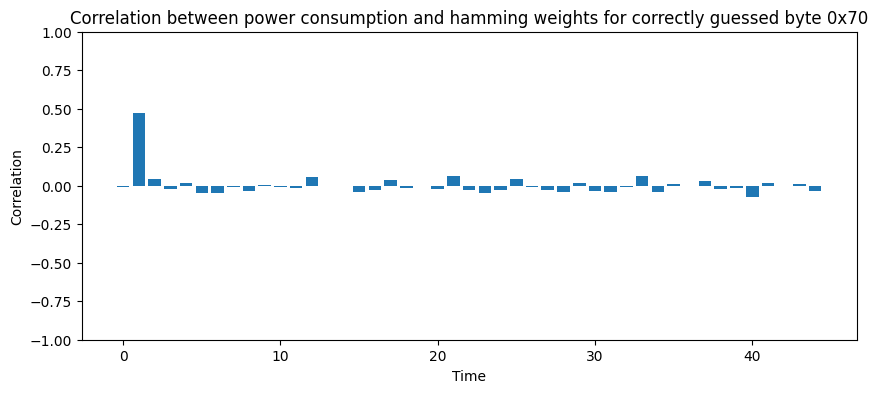

In [33]:
# Print correlation in comparison to time

guessed_key = np.zeros((4,), dtype=np.uint32)
guessed_byte = key[3] & 0xFF
guessed_key[3] |= guessed_byte

expected_hws = np.array(
        [get_hw_for_guessed_key_byte(m.plaintext, guessed_key, 0, np.uint32(0xFF)) for m in measurements.entries], 
        dtype=np.uint32)

correlations = np.array(
        [
            np.corrcoef(expected_hws, measurements.power_2d[:, t])[0, 1]
            for t in range(measurements.power_2d.shape[1])
        ],
        dtype=np.float64,
    )

plt.figure(figsize=(10,4))
x = np.arange(len(correlations))
plt.bar(x, correlations)
plt.xlabel("Time")
plt.ylabel("Correlation")
plt.title(f"Correlation between power consumption and hamming weights for correctly guessed byte 0x{guessed_byte:02X}")
plt.ylim(-1, 1)
plt.show()

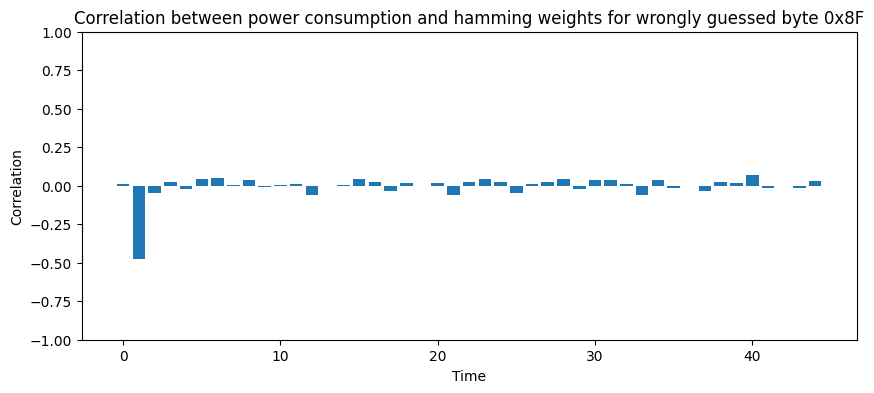

In [36]:
# Print correlation in comparison to time

guessed_key = np.zeros((4,), dtype=np.uint32)
guessed_byte = ~key[3] & 0xFF
guessed_key[3] |= guessed_byte

expected_hws = np.array(
        [get_hw_for_guessed_key_byte(m.plaintext, guessed_key, 0, np.uint32(0xFF)) for m in measurements.entries], 
        dtype=np.uint32)

correlations = np.array(
        [
            np.corrcoef(expected_hws, measurements.power_2d[:, t])[0, 1]
            for t in range(measurements.power_2d.shape[1])
        ],
        dtype=np.float64,
    )

plt.figure(figsize=(10,4))
x = np.arange(len(correlations))
plt.bar(x, correlations)
plt.xlabel("Time")
plt.ylabel("Correlation")
plt.title(f"Correlation between power consumption and hamming weights for wrongly guessed byte 0x{guessed_byte:02X}")
plt.ylim(-1, 1)
plt.show()


Find correlations for 256 hypotheses.


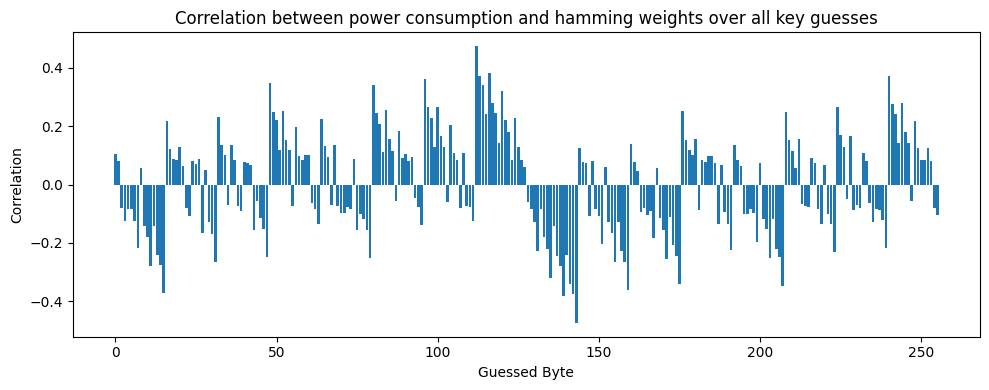

In [35]:
# start with empty key as hypothesis
empty_key = np.zeros((4,), dtype=np.uint32)
start_hypo = KeyHypothesis(empty_key, 0)

hypos = start_hypo.get_sub_hypos()

print(f"Find correlations for {len(hypos)} hypotheses.")

for hypo in hypos:
    calc_corr_for_hypo(hypo, measurements)

corrs = [h.corr for h in hypos]
    
plt.figure(figsize=(10,4))
x = np.arange(len(corrs))
plt.bar(x, corrs)
plt.xlabel("Guessed Byte")
plt.ylabel("Correlation")
plt.title(f"Correlation between power consumption and hamming weights over all key guesses")
plt.tight_layout()
plt.show()